``` 
1. Importa las librerías necesarias para aplicar preprocesamiento de datos,
visualización y creación de un modelo de red neuronal feedforward con Keras y
Tensorflow, además de las librerías para realizar regularización y búsqueda de grilla.

In [115]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, HeNormal
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    MinMaxScaler,
    StandardScaler,
)
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
# Cargar el dataset
url = "hotel_bookings.csv"  # Reemplaza con la ruta de tu archivo CSV
df = pd.read_csv(url)

df

,index,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,0,Resort Hotel,0,342,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,01-07-15
1,1,Resort Hotel,0,737,2015,July,27,1,0,0,...,No Deposit,NaN,NaN,0,Transient,0.00,0,0,Check-Out,01-07-15
2,2,Resort Hotel,0,7,2015,July,27,1,0,1,...,No Deposit,NaN,NaN,0,Transient,75.00,0,0,Check-Out,02-07-15
3,3,Resort Hotel,0,13,2015,July,27,1,0,1,...,No Deposit,304.0,NaN,0,Transient,75.00,0,0,Check-Out,02-07-15
4,4,Resort Hotel,0,14,2015,July,27,1,0,2,...,No Deposit,240.0,NaN,0,Transient,98.00,0,1,Check-Out,03-07-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,119385,City Hotel,0,23,2017,August,35,30,2,5,...,No Deposit,394.0,NaN,0,Transient,96.14,0,0,Check-Out,06-09-17
119386,119386,City Hotel,0,102,2017,August,35,31,2,5,...,No Deposit,9.0,NaN,0,Transient,225.43,0,2,Check-Out,07-09-17
119387,119387,City Hotel,0,34,2017,August,35,31,2,5,...,No Deposit,9.0,NaN,0,Transient,157.71,0,4,Check-Out,07-09-17
119388,119388,City Hotel,0,109,2017,August,35,31,2,5,...,No Deposit,89.0,NaN,0,Transient,104.40,0,0,Check-Out,07-09-17


```
Luego, debes descartar las columnas index, arrival_date_year, agent, country,
company, reservation_status y reservation_status_date. Revisa después si la base

de datos presenta valores ausentes; en el caso que existan deberá eliminar estos
registros siempre y cuando la cantidad sea menor al 4% del total. En caso que sea
superior debes decidir si quitar la característica o imputar los datos faltantes
aplicando alguna estrategía, que debes describir.


In [116]:
# Eliminar columnas no deseadas
columns_to_drop = [
    "index",
    "arrival_date_year",
    "agent",
    "country",
    "company",
    "reservation_status",
    "reservation_status_date",
]
df = df.drop(columns=columns_to_drop)

# Revisar valores ausentes
missing_values = df.isnull().sum()
missing_values_percent = (missing_values / df.shape[0]) * 100
print(missing_values_percent[missing_values_percent > 0])

# Eliminar registros con valores ausentes si son menos del 4%
df = df.dropna(thresh=(1 - 0.04) * df.shape[1], axis=0)

# Imputar valores faltantes si existen columnas con más del 4% de valores faltantes
for column in df.columns:
    if df[column].isnull().sum() / len(df) > 0.04:
        if df[column].dtype == "object":
            df = df.drop(columns=[column])
        else:
            df[column] = df[column].fillna(df[column].mean())
    else:
        df = df.dropna(subset=[column])

print(df.isnull().sum())

children    0.00335
dtype: float64
hotel                             0
is_canceled                       0
lead_time                         0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
market_segment                    0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
assigned_room_type                0
booking_changes                   0
deposit_type                      0
days_in_waiting_list              0
customer_type                     0
adr                               0
required_car_parking_spaces       0
total_of_special_requests         0
dtype: int64


```
 2. Realiza un análisis descriptivo y prepara los datos. Para esto:
a. Selecciona 5 variables que consideres relevantes (que no sean la variable
adr) con respecto a cancelar una reserva.


In [117]:
# Paso 2: Análisis descriptivo y preparación de datos
selected_columns = [
    "lead_time",
    "stays_in_weekend_nights",
    "stays_in_week_nights",
    "previous_cancellations",
    "total_of_special_requests",
]
df_selected = df[selected_columns + ["is_canceled"]]

```
b. Construye un histograma para la variable adr con reservas canceladas y no
canceladas, y comenta el resultado.


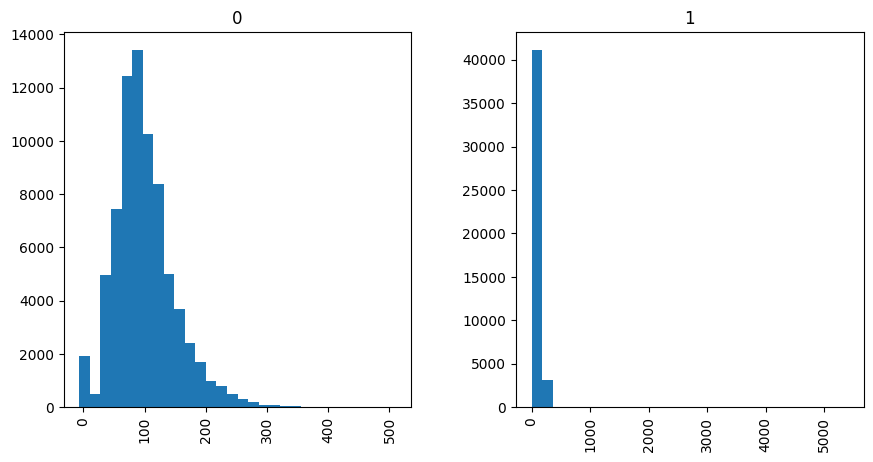

In [118]:
# Crear histogramas para la variable 'adr' con reservas canceladas y no canceladas
df["adr"].hist(by=df["is_canceled"], bins=30, figsize=(10, 5))
plt.show()

```
c. Revisa la presencia de outlier para la variable adr. En caso que presente
valores extremos indica la cantidad de outliers por arriba, y la cantidad de
outlier por abajo. Eliminar sólo los tres valores más extremos en ambos
casos, para los demás cambia sus valores por el valor promedio de la
variable.


In [119]:
# Identificar y manejar outliers en 'adr'
Q1 = df["adr"].quantile(0.25)
Q3 = df["adr"].quantile(0.75)
IQR = Q3 - Q1

outliers_upper = df[df["adr"] > (Q3 + 1.5 * IQR)]
outliers_lower = df[df["adr"] < (Q1 - 1.5 * IQR)]

print(f"Outliers por arriba: {len(outliers_upper)}")
print(f"Outliers por abajo: {len(outliers_lower)}")

Outliers por arriba: 3793
Outliers por abajo: 0


In [120]:
# Eliminar solo los tres valores más extremos
df = df.sort_values(by="adr")
df = df.iloc[3:-3]

# Reemplazar los otros outliers por el valor promedio
mean_adr = df["adr"].mean()
df.loc[df["adr"] > (Q3 + 1.5 * IQR), "adr"] = mean_adr
df.loc[df["adr"] < (Q1 - 1.5 * IQR), "adr"] = mean_adr

``` 
d. Transforma las variables categóricas en variables dummies, estandariza las
variables independientes con media igual a cero y desviación estándar 1 y
realiza una división de los datos para entrenamiento y test, este último con un
33% de registros.

In [121]:
# Transformar variables categóricas en variables dummies
df = pd.get_dummies(df, drop_first=True)

# Verificar las columnas después de crear dummies
print(df.columns)

# Estandarizar las variables independientes
scaler = StandardScaler()
X = df.drop("is_canceled", axis=1)
y = df["is_canceled"]
X_scaled = scaler.fit_transform(X)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.33, random_state=42, stratify=y
)

Index(['is_canceled', 'lead_time', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'hotel_Resort Hotel',
       'arrival_date_month_August', 'arrival_date_month_December',
       'arrival_date_month_February', 'arrival_date_month_January',
       'arrival_date_month_July', 'arrival_date_month_June',
       'arrival_date_month_March', 'arrival_date_month_May',
       'arrival_date_month_November', 'arrival_date_month_October',
       'arrival_date_month_September', 'meal_FB', 'meal_HB', 'meal_SC',
       'meal_Undefined', 'market_segment_Complementary',
       'market_segment_Corporate', 'market_segment_Direct',
       'market_segment_Groups', 'market_segment_Offline 

```
3. Implementa dos modelos de red neuronal multicapa, considerando las siguientes
características.


a. Cada modelo debe contar con tres capas ocultas

b. El primer modelo debe tener funciones de activación tanh, relu y tanh en las
capas ocultas, mientras que el segundo sólo funciones tanh en sus capas
ocultas.

c. Cada modelo debe tener un mínimo de 20 neuronas para cada capa oculta.
Use un optimizador SGD, con 10 épocas de entrenamiento; cada capa deberá
tener una neurona de sesgo. Debes decidir cómo se inicializan los pesos y el
sesgo en cada capa oculta y de salida.

In [122]:
# Paso 3: Implementación de modelos de red neuronal multicapa


# Modelo 1: Capas ocultas con tanh, relu y tanh
def build_model1():
    model = Sequential(
        [
            Dense(
                20,
                activation="tanh",
                kernel_initializer=GlorotNormal(),
                bias_initializer="zeros",
                input_shape=(X_train.shape[1],),
            ),
            Dense(
                20,
                activation="relu",
                kernel_initializer=GlorotNormal(),
                bias_initializer="zeros",
            ),
            Dense(
                20,
                activation="tanh",
                kernel_initializer=GlorotNormal(),
                bias_initializer="zeros",
            ),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])
    return model


model1 = build_model1()
history1 = model1.fit(
    X_train, y_train, validation_split=0.33, epochs=10, batch_size=32, verbose=1
)

Epoch 1/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6854 - loss: 0.5856 - val_accuracy: 0.7864 - val_loss: 0.4592
Epoch 2/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7969 - loss: 0.4423 - val_accuracy: 0.7969 - val_loss: 0.4349
Epoch 3/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8065 - loss: 0.4203 - val_accuracy: 0.8018 - val_loss: 0.4238
Epoch 4/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8129 - loss: 0.4059 - val_accuracy: 0.8043 - val_loss: 0.4165
Epoch 5/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8168 - loss: 0.3948 - val_accuracy: 0.8053 - val_loss: 0.4115
Epoch 6/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8123 - loss: 0.4002 - val_accuracy: 0.8081 - val_loss: 0.4086
Epoch 7/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8177 - loss: 0.3911 - val_accuracy: 0.8103 - val_loss: 0.4040
Epoch 8/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8184 - loss: 0.3868 - 

In [123]:
# Modelo 2: Capas ocultas solo con tanh
def build_model2():
    model = Sequential(
        [
            Dense(
                20,
                activation="tanh",
                kernel_initializer=GlorotNormal(),
                bias_initializer="zeros",
                input_shape=(X_train.shape[1],),
            ),
            Dense(
                20,
                activation="tanh",
                kernel_initializer=GlorotNormal(),
                bias_initializer="zeros",
            ),
            Dense(
                20,
                activation="tanh",
                kernel_initializer=GlorotNormal(),
                bias_initializer="zeros",
            ),
            Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer=SGD(), loss="binary_crossentropy", metrics=["accuracy"])
    return model


model2 = build_model2()
history2 = model2.fit(
    X_train, y_train, validation_split=0.33, epochs=10, batch_size=32, verbose=1
)

Epoch 1/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7130 - loss: 0.5718 - val_accuracy: 0.7847 - val_loss: 0.4587
Epoch 2/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7953 - loss: 0.4388 - val_accuracy: 0.7948 - val_loss: 0.4365
Epoch 3/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8051 - loss: 0.4182 - val_accuracy: 0.8000 - val_loss: 0.4251
Epoch 4/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8085 - loss: 0.4119 - val_accuracy: 0.8047 - val_loss: 0.4163
Epoch 5/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8135 - loss: 0.4023 - val_accuracy: 0.8036 - val_loss: 0.4130
Epoch 6/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8149 - loss: 0.3975 - val_accuracy: 0.8038 - val_loss: 0.4094
Epoch 7/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8151 - loss: 0.3944 - val_accuracy: 0.8096 - val_loss: 0.4060
Epoch 8/10
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8174 - loss: 0.3922 - 

```
Muestra los resultados en un gráfico que tendrá una curva de accuracy para cada
modelo en cada época de entrenamiento. Cada modelo debe lograr un accuracy
superior al 75%. Concluye de acuerdo a los resultados.


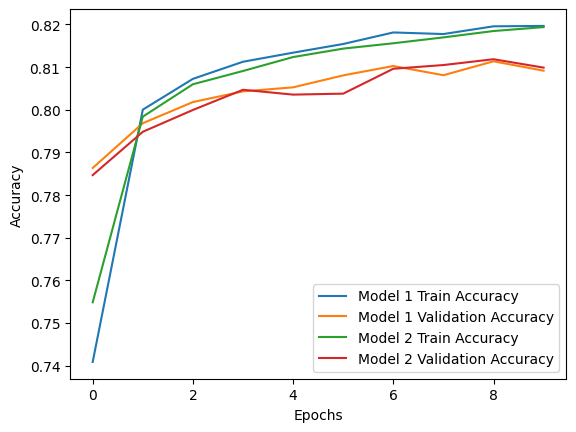

In [124]:
# Curvas de accuracy
plt.plot(history1.history["accuracy"], label="Model 1 Train Accuracy")
plt.plot(history1.history["val_accuracy"], label="Model 1 Validation Accuracy")
plt.plot(history2.history["accuracy"], label="Model 2 Train Accuracy")
plt.plot(history2.history["val_accuracy"], label="Model 2 Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

tanto el modelo 1 como el modelo 2 tienen un accuracy mayor al 80% y se estabilizan en la epoca 8

```
4. Construye una red neuronal con regularización Dropout aplicando búsqueda de grilla
para tres fold. El modelo debe conseguir un accuracy superior al 80%. La búsqueda
debe sintonizar los siguientes hiper parámetros:
a. Cantidad de capas ocultas: de 3 o 4
b. Método de optimización: Adam o SGD
c. learning_rate: 0.03 y 0.06
d. Cantidad de neuronas en las capas ocultas: 20
e. Funciones de activación en las capas ocultas: tanh
f. Rate para Dropout: 0.001
g. Inicialización de los pesos: [glorot_normal, glorot_uniform]


In [128]:
# Paso 4: Red neuronal con regularización Dropout y búsqueda de grilla


# Definición del modelo con Dropout
def build_model_with_dropout(
    n_layers=3,
    n_neurons=20,
    activation="tanh",
    dropout_rate=0.001,
    optimizer="adam",
    learning_rate=0.01,
    kernel_initializer="glorot_normal",
):
    if kernel_initializer == "glorot_normal":
        kernel_initializer = GlorotNormal()
    elif kernel_initializer == "glorot_uniform":
        kernel_initializer = GlorotUniform()

    model = Sequential()
    model.add(
        Dense(
            n_neurons,
            activation=activation,
            kernel_initializer=kernel_initializer,
            bias_initializer="zeros",
            input_shape=(X_train.shape[1],),
        )
    )
    for _ in range(n_layers - 1):
        model.add(
            Dense(
                n_neurons,
                activation=activation,
                kernel_initializer=kernel_initializer,
                bias_initializer="zeros",
            )
        )
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    if optimizer == "adam":
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

Fitting 3 folds for each of 16 candidates, totalling 48 fits
1675/1675 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7897 - loss: 0.4476 - val_accuracy: 0.8052 - val_loss: 0.4111
Mejores Parametros: 0.8087491785125636 using {'model__activation': 'tanh', 'model__dropout_rate': 0.001, 'model__kernel_initializer': 'glorot_normal', 'model__n_layers': 3, 'model__n_neurons': 20, 'optimizer': 'adam', 'optimizer__learning_rate': 0.03}
1232/1232 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Matriz de confusión:
[[22343  2461]
 [ 5105  9487]]


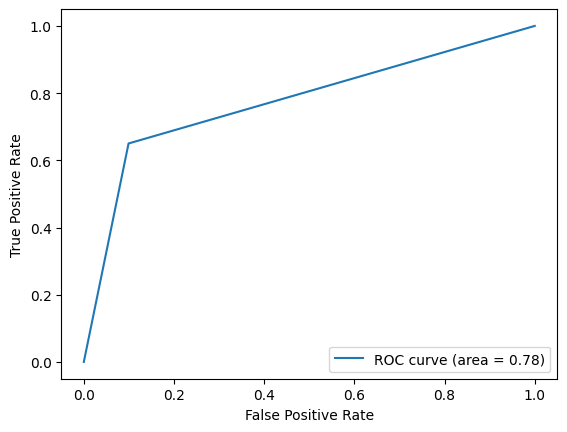

In [132]:
# Búsqueda de grilla
from scikeras.wrappers import KerasClassifier

clf = KerasClassifier(
    model=build_model_with_dropout,
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"],
    validation_split=0.33,
    verbose=1,
)

param_grid = {
    "model__n_layers": [3, 4],
    "optimizer": ["adam", "sgd"],
    "optimizer__learning_rate": [0.03, 0.06],
    "model__n_neurons": [20],
    "model__activation": ["tanh"],
    "model__dropout_rate": [0.001],
    "model__kernel_initializer": ["glorot_normal", "glorot_uniform"],
}

grid = GridSearchCV(
    estimator=clf, param_grid=param_grid, scoring="accuracy", cv=3, n_jobs=-1, verbose=1
)
grid_result = grid.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros encontrados
print(f"Mejores Parametros: {grid_result.best_score_} using {grid_result.best_params_}")

# Evaluar el mejor modelo en el conjunto de prueba
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Matriz de confusión:\n{conf_matrix}")

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

Proceso de Búsqueda de Hiperparámetros
Durante la búsqueda de hiperparámetros, se ajustaron 3 folds para cada uno de los 16 candidatos, resultando en un total de 48 ajustes. El modelo final se entrenó con una precisión de entrenamiento de 0.7897 y una pérdida de 0.4476. La precisión de validación alcanzó 0.8052 con una pérdida de validación de 0.4111.

Mejores Hiperparámetros Encontrados
Los mejores hiperparámetros encontrados fueron:

Función de Activación: tanh
Rate de Dropout: 0.001
Inicialización del Kernel: glorot_normal
Número de Capas Ocultas: 3
Número de Neuronas por Capa: 20
Optimizador: adam
Learning Rate del Optimizador: 0.03
Estos hiperparámetros proporcionaron una precisión media de 0.8087 en los conjuntos de validación.

Evaluación del Modelo en el Conjunto de Prueba
La matriz de confusión del mejor modelo en el conjunto de prueba es:
[[22343  2461]
 [ 5105  9487]]

Interpretación de la Matriz de Confusión
Verdaderos Negativos (TN): 22343
Falsos Negativos (FN): 5105
Falsos Positivos (FP): 2461
Verdaderos Positivos (TP): 9487
La matriz de confusión indica que el modelo tiene:

Una buena capacidad para identificar reservas no canceladas (TN = 22343).
Una tasa razonable de identificación de reservas canceladas (TP = 9487).
Un número moderado de falsos positivos (FP = 2461), lo que indica algunas predicciones incorrectas de cancelaciones.
Un número considerable de falsos negativos (FN = 5105), lo que sugiere que algunas cancelaciones no fueron predichas correctamente.
Reporte de Clasificación
Calculamos el reporte de clasificación para obtener métricas más detalladas:
               precision    recall  f1-score   support

           0       0.81      0.90      0.85     24804
           1       0.79      0.65      0.71     14592

    accuracy                           0.80     39396
   macro avg       0.80      0.78      0.78     39396
weighted avg       0.80      0.80      0.80     39396





``` 
5. Del conjunto original (sin los valores excluidos) escoge al azar cinco observaciones
en que “deposit_type_Non Refund” sea cero, y con esto realiza una predicción
usando el mejor modelo encontrado por la búsqueda de grilla anterior. Comenta los
resultados.

In [131]:

# Seleccionar cinco observaciones aleatorias donde 'deposit_type_Non Refund' sea cero
df_sample = df[df["deposit_type_Non Refund"] == 0].sample(n=5, random_state=42)

# Preparar los datos de estas observaciones para predicción
X_sample = scaler.transform(df_sample.drop("is_canceled", axis=1))

# Realizar predicciones
predictions = best_model.predict(X_sample)
print(f"Predictions: {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predictions: [0 0 0 1 0]
